In [23]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from wpca import WPCA # JVDP's weighted PCA library
%matplotlib inline

In [2]:
def ccd_noise_equation(t, n_star, be, de, rho, npix, pb):
    '''
    t: exposure time (s)
    n_star: photons per t (e- . s^-1)
    be: background rate (e- . s^-1 . per pix)
    de: dark rate (e- . s^-1 . per pix)
    rho: readout noise (e-)
    npix: number of source aperture pixels
    pb: sky section pixels
    '''
    signal = n_star * t
    shot_and_dark_var = t * (n_star + npix*(1 + (npix/pb))*(be + de))
    read_var = npix * (1 + (npix / pb)) * (rho**2)
    noise = np.sqrt(shot_and_dark_var + read_var)
    return signal / noise

In [3]:
def ccd_noise_equation(t, n_star, be, de, rho, npix, pb,
                      D, gamma, h_obs, H=8000):
    '''
    t: exposure time (s)
    n_star: photons per t (e- . s^-1)
    be: background rate (e- . s^-1 . per pix)
    de: dark rate (e- . s^-1 . per pix)
    rho: readout noise (e-)
    npix: number of source aperture pixels
    pb: sky section pixels
    '''
    signal = n_star * t
    shot_and_dark_var = t * (n_star + npix*(1 + (npix/pb))*(be + de))
    #shot_and_dark_var = signal + npix * (t * de)
    read_var = npix * (1 + (npix / pb)) * (rho**2)
    scint_var = 9e-6 * (D ** (-4/3)) * (1/t) * (np.cos(gamma) ** -3) * np.exp(-2 * h_obs / H)
    #print(np.sqrt(shot_and_dark_var), signal * np.sqrt(scint_var))
    noise = np.sqrt(shot_and_dark_var + read_var + (signal**2 * scint_var))
    return signal / noise

In [4]:
def emccd_noise_equation(t, n_star, be, c, rho, G, npix, pb,
                      D, gamma, h_obs, H=8000):
    '''
    t: exposure time (s)
    n_star: photons per t (e- . s^-1)
    be: background rate (e- . s^-1 . per pix)
    c: spurious charge (e- . s^-1 . per pix)
    rho: readout noise (e_EM-)
    G: EM gain (e_EM / e-)
    npix: number of source aperture pixels
    pb: sky section pixels
    '''
    signal = n_star * t
    shot_and_dark_var = t * (n_star + npix*(1 + (npix/pb))*(be + c))
    scint_var = 9e-6 * (D ** (-4/3)) * (1/t) * (np.cos(gamma) ** -3) * np.exp(-2 * h_obs / H)
    read_var = npix * (1 + (npix / pb)) * (rho / G) ** 2
    noise = np.sqrt(2 * (shot_and_dark_var) + read_var + (signal**2 * scint_var))
    return signal / noise

In [5]:
## computing n_star
# mVega = 0
#flam_Vega = 3.61e-11 # W m-2 nm-1 (V-band)
#lam = 550e-9 # nm (V-band)

flam_Vega = 2.177e-11 # W m-2 nm-1 (R-band)
mVega = 0.07 # (R-band)
lam = 644e-9 # nm (R-band)

def photon_rate(mag, mref, fref, lam, h=6.63e-34, c=3e8):
    
    '''
    mag: magnitude of target
    fref: monochromatic reference flux at lam
    lam: effective wavelength [m]
    h: planck constant
    c: speed of light
    '''

    # mref = 0 by definition
    #flux = fref * (10 ** (mag / (-2.5)))
    flux = fref * 10**(0.4 * (mref - mag))
    
    # number of photons in s-1 . m-2 . nm-1
    n_ = flux * lam / (h * c)
    
    return n_
    
def telescope_photon_rate(n_, D, del_lam=86, q=1):
    '''
    n_: photon rate
    D: telescope mirror diameter [m]
    del_lam: bandwidth [nm]
    q: overall efficiency (telscope/instrument/filter/detector)
    '''
    return n_ * np.pi * (D/2)**2 * del_lam * q

In [6]:
from astropy.io import fits
import numpy as np
hdul0 = fits.open('C:/Users/James/kinetix_data_system/lab_tests/data_system_lab/notebooks/snr_references/new-image.fits')
hdul1 = fits.open('C:/Users/James/kinetix_data_system/lab_tests/data_system_lab/notebooks/snr_references/new-image_speed.fits')

In [7]:
from astropy.wcs import WCS
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astropy.coordinates import Angle
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import mad_std

def Xmatch(hdul, pos_path):
    
    w = WCS(hdul[0].header)

    # load source positions (x,y)
    pos = np.load(pos_path)
    
    print(pos.shape)

    # convert to RA and DEC
    coords = w.pixel_to_world(pos[:,0], pos[:,1])
    
    ra = []
    dec = []
    for crd in coords:
        ra.append(crd.ra.deg)
        dec.append(crd.dec.deg)
        

    # pull catalogue information and X-match
    # catalogue output row limit
    Vizier.ROW_LIMIT = 100000


    result = Vizier.query_region(coord.ICRS(ra=282.769*u.deg, dec=-6.278*u.deg),
                     radius=Angle(0.08, "deg"),
                     catalog='PanSTARRS')
    
    print(result)


    # catalogue
    cat = result[0]

    # catalogue coordinates
    ref_ra, ref_dec = cat['RAJ2000'], cat['DEJ2000']

    ## X-match! ##
    print('Starting Xmatch...')
    i=0 # SExtractor index

    output = np.zeros((0,3))
    for i in range(0, len(ra)):
        delta_ra = abs((ra[i]-ref_ra)*np.cos(dec[i]*np.pi/180))
        delta_dec = abs(dec[i] - ref_dec)
        separations = np.array([])
        cat_index = np.array([])
        separations = np.sqrt(delta_ra**2 + delta_dec**2)
        cat_index = np.arange(0, len(delta_ra), 1)
        best_match = cat_index[np.where(separations == np.min(separations))][0]
        output = np.append(output,[[i, best_match, np.min(separations)]], axis=0)
        i+=1

    ## reject sources that don't meet tolerance condition ##
    tol = 2./3600

    output = output[np.where(output[:,2] <= tol)]
    print('Number of matched sources:', len(output))
    
    rmags = cat['rmag'][output[:,1].astype(int)]
    gmags = cat['gmag'][output[:,1].astype(int)]
    
    return rmags, gmags, output

In [8]:
pospath0 = "E:/McDonald backups/results_M11_Sept20_2/positions.npy"
pospath1 = "E:/McDonald backups/results_M11_Sept20_speed3/positions.npy"
rmags0, gmags0, output0 = Xmatch(hdul0, pospath0)
rmags1, gmags1, output1 = Xmatch(hdul1, pospath1)

(282, 2)
TableList with 1 tables:
	'0:II/349/ps1' with 35 column(s) and 16200 row(s) 
Starting Xmatch...
Number of matched sources: 282
(269, 2)
TableList with 1 tables:
	'0:II/349/ps1' with 35 column(s) and 16200 row(s) 
Starting Xmatch...
Number of matched sources: 269


In [9]:
len(rmags0), len(rmags1), len(gmags0), len(gmags1), len(output0), len(output1)

(282, 269, 282, 269, 282, 269)

In [10]:
#s = [s for d, s, f in os.walk('McDonald backups')][0]
subdirs = [s for d, s, f in os.walk('E:/McDonald backups') ][0]
subdirs = [s for s in subdirs if 'results' in s ]

In [35]:
# number of PCA components to be used by the model
N_COMPONENTS = 8

# size of chunks for which to slice up the light curve to fit it into computer memory
CHUNK_SIZE = 2500

def compute_snr(path, rmags, output, ap_diam):
    # load data and generate a matrix of observations
    #path = '/media/jah94/Seagate_Expansion_Drive#2/McDonald backups/results_M11_Sept20_2'

    files = [f for d, s, f in os.walk(path)][0]

    # order the files
    phot_files = []
    seq_files = []
    sky_files = []
    batch_ids = np.arange(0, 1000).astype(str)
    for b in batch_ids:
        for f in files:
            if 'photometry' in f and 'batch' + b + '.npy' in f:
                phot_files.append(f)
            elif 'seq' in f and 'batch' + b + '.npy' in f:
                seq_files.append(f)
            elif 'sky' in f and 'batch' + b + '.npy' in f:
                sky_files.append(f)
                
    positions = np.load(os.path.join(path, 'positions.npy'))
    bb_pos = np.load(os.path.join(path, 'bb_pos.npy'))
    
    n = 0 # use as reference for array dimensions
    fs = np.load(os.path.join(path, phot_files[n])) # use for shape info
    ss = np.load(os.path.join(path, sky_files[n]))
    data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
    t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
    bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

    # staple together the data in files
    def batch_files(files, arr):
        for i,file in enumerate(files):
            arr[i] = np.load(os.path.join(path, file))
        return arr

    data = batch_files(phot_files, data)
    t = batch_files(seq_files, t)
    bkgs = batch_files(sky_files, bkgs)
    
    # reshape and change dtype
    data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
    bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
    t = t.flatten().astype(np.float32)
    

    # generate observatons matrix (n_samples x n_features)
    X = np.copy(data)
    
    print(X[:,0])
    
    print((ap_diam**2) * np.median(bkgs, axis=1))
    
    # subtract background estimate from the observations
    X -= (ap_diam**2) * np.median(bkgs, axis=1)[:, None]
    
    print(X[:,0])
    
    b_adu = np.median(bkgs)
    print('b_adu [ADU / pix / s]:', b_adu)
    
    # normalise the flux measurements
    X_norm = X / np.median(X, axis=0)
    
    ###################### fit WPCA model #########################
    X_norm = X_norm.T  # reshape to data matrix is n_samples x n_features
    print('Data matrix shape:', X_norm.shape)
    X_norm -= np.median(X_norm, axis=1)[:, None] # centre rows
    
    #X_norm = X_norm[[0, 10, 50, 100, 150, 200], :]

    # split time series into manageable chunks
    T = X_norm.shape[1]
    chunks = np.concatenate((np.arange(0, T, CHUNK_SIZE), np.array([T])))
    residuals = np.ones(X_norm.shape) # destination array for the residuals

    print('Fitting PCA model...')
    for source in range(0,len(X_norm)):
        print('Source %d / %d' % (source + 1, len(X_norm)))
        for i in tqdm(range(len(chunks)-1)):

            # slice out data chunk
            X_norm_ = X_norm[:,chunks[i]:chunks[i+1]]

            # define weights as the inverse of the (normalised) time series variance
            weights = 1/np.var(X_norm_, axis=1)
            weights = weights[:,None] * np.ones(X_norm_.shape)
            weights[source] = 1e-6 * np.ones(weights[source].shape) # weight out the target star (using 0s result in Singular matrix error)
            pca = WPCA(n_components=N_COMPONENTS).fit(X_norm_, weights=weights) # fit pca model
            Y = pca.fit_reconstruct(X_norm_, weights=weights) # make predictions

            # compute residuals (i.e. "detrended" time series)
            residuals_ = X_norm_[source] - Y[source]
            residuals_ += 1 # shift time series such that median I(t) is 1

            # slice reiduals into the destination array
            residuals[source,chunks[i]:chunks[i+1]] = residuals_
    
    snrs = []
    for lc in tqdm(residuals):
        # skip lc if noise exceeds some threshold
        mstd = mad_std(lc) # light curve median absolute deviation
        snrs.append(1. / mstd)

    '''
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]
    print("Number of comparison stars:", len(comparison_stars))
    #wav = np.average(X_norm[:, comparison_stars],
    #                 #weights=np.sqrt(np.median(X[:, comparison_stars], axis=0)), axis=1)
    #                 weights=np.std(X_norm[:, comparison_stars], axis=0), axis=1)
    
    snrs = []
    for i in range(X_norm.shape[1]):
        if i in output[:,0]:
            comp_stars = [c for c in comparison_stars if c != i]
            wav = np.average(X_norm[:, comp_stars],
                     #weights=np.std(X_norm[:, comp_stars], axis=0), axis=1)
                     weights=1/np.var(X_norm[:, comp_stars], axis=0), axis=1)
            lc_corr = X_norm[:, i] / wav
            snrs.append(1 / mad_std(lc_corr))
    '''
    
        
    return snrs, b_adu

In [36]:
path0 = "E:/McDonald backups/results_M11_Sept20_2"
#path1 = "E:/McDonald backups/results_M11_Sept20_speed3"
snrs0, b_adu_0 = compute_snr(path0, rmags0, output0, ap_diam=58)
#snrs1, b_adu_1 = compute_snr(path1, rmags1, output1, ap_diam=30)

[536277.   519328.53 527083.4  ... 448553.9  452614.28 459838.4 ]
[441.03705 538.60425 501.76727 ... 205.9504  384.54666 210.96523]
[535835.94 518789.94 526581.6  ... 448347.97 452229.75 459627.44]
b_adu [ADU / pix / s]: 0.11218467
Data matrix shape: (282, 290000)
Fitting PCA model...
Source 1 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]


Source 2 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 3 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 4 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 5 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 6 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 7 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 8 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 9 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 10 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 11 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 12 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 13 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 14 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 15 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 16 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 17 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 18 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 19 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.17it/s]


Source 20 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 21 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 22 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]


Source 23 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 24 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 25 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 26 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 27 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 28 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 29 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.17it/s]


Source 30 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 31 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 32 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 33 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 34 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 35 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 36 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 37 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 38 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 39 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 40 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 41 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 42 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 43 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 44 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.20it/s]


Source 45 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 46 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 47 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 48 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 49 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 50 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 51 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 52 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 53 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 54 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 55 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.17it/s]


Source 56 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 57 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 58 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 59 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 60 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 61 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 62 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 63 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 64 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 65 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 66 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 67 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 68 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 69 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 70 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 71 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 72 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 73 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 74 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 75 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 76 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 77 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 78 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 79 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 80 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 81 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 82 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 83 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 84 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 85 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 86 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 87 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 88 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 89 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 90 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 91 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 92 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 93 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 94 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 95 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:35<00:00,  1.21it/s]


Source 96 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 97 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 98 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 99 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 100 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 101 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 102 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 103 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 104 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 105 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 106 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 107 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 108 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 109 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 110 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 111 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 112 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 113 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 114 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 115 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 116 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 117 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 118 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 119 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 120 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 121 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 122 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 123 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 124 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 125 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 126 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 127 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 128 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.17it/s]


Source 129 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 130 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 131 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 132 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 133 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 134 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 135 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 136 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 137 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 138 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 139 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 140 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 141 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]


Source 142 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 143 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 144 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 145 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 146 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 147 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 148 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16it/s]


Source 149 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 150 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 151 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 152 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 153 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 154 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 155 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 156 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 157 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 158 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 159 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 160 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:34<00:00,  1.22it/s]


Source 161 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 162 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 163 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 164 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 165 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 166 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 167 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:35<00:00,  1.22it/s]


Source 168 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 169 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 170 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 171 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 172 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 173 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 174 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 175 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 176 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 177 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 178 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 179 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 180 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16it/s]


Source 181 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 182 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 183 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 184 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 185 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 186 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 187 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 188 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 189 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 190 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 191 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 192 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 193 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 194 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 195 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 196 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 197 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 198 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 199 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 200 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 201 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 202 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 203 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:35<00:00,  1.22it/s]


Source 204 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 205 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 206 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.20it/s]


Source 207 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 208 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 209 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.20it/s]


Source 210 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 211 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 212 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 213 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


Source 214 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 215 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:36<00:00,  1.21it/s]


Source 216 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 217 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:35<00:00,  1.21it/s]


Source 218 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 219 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 220 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 221 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 222 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 223 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 224 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 225 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 226 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 227 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]


Source 228 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 229 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 230 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 231 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19it/s]


Source 232 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:37<00:00,  1.18it/s]


Source 233 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16it/s]


Source 234 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 235 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]


Source 236 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 237 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 238 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16it/s]


Source 239 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16it/s]


Source 240 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18it/s]


Source 241 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:35<00:00,  1.22it/s]


Source 242 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:33<00:00,  1.24it/s]


Source 243 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:32<00:00,  1.25it/s]


Source 244 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 245 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 246 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.30it/s]


Source 247 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 248 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.30it/s]


Source 249 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.34it/s]


Source 250 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.33it/s]


Source 251 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.32it/s]


Source 252 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.34it/s]


Source 253 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.33it/s]


Source 254 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.34it/s]


Source 255 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.33it/s]


Source 256 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:26<00:00,  1.34it/s]


Source 257 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.32it/s]


Source 258 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 259 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 260 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.33it/s]


Source 261 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.30it/s]


Source 262 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.32it/s]


Source 263 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 264 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.29it/s]


Source 265 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.30it/s]


Source 266 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 267 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:30<00:00,  1.29it/s]


Source 268 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.29it/s]


Source 269 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.29it/s]


Source 270 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.29it/s]


Source 271 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:30<00:00,  1.28it/s]


Source 272 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 273 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:30<00:00,  1.29it/s]


Source 274 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 275 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.30it/s]


Source 276 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 277 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:29<00:00,  1.30it/s]


Source 278 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 279 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:28<00:00,  1.31it/s]


Source 280 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.32it/s]


Source 281 / 282


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:27<00:00,  1.32it/s]


Source 282 / 282


100%|███████████████████████████████████████████████████████████████████████████████| 282/282 [00:01<00:00, 144.62it/s]


In [37]:
len(rmags0), len(rmags1), len(gmags0), len(gmags1), len(snrs0)#, len(snrs1)

(282, 269, 282, 269, 282)

In [38]:
snrs0

[54.72824200586165,
 48.83987878742004,
 49.0292462117354,
 45.01428958113822,
 47.98386770148476,
 46.907763952513875,
 48.9632154948945,
 45.95964141705327,
 46.24374318106911,
 46.989242686637056,
 44.96802382453583,
 46.91252795506651,
 44.216993216921544,
 41.27642488552765,
 38.26864909585895,
 44.124740355521176,
 40.02692047188665,
 37.91852876730716,
 42.644805391773446,
 39.94962312091739,
 39.32650350012967,
 40.060990973979166,
 42.362332904746026,
 36.83292101120619,
 35.97763335279942,
 37.538566764108275,
 36.90947961528806,
 36.54434607544881,
 32.830500089118075,
 33.301547616674966,
 36.426231004907294,
 37.048511322166895,
 30.975261672877814,
 31.17941635557633,
 32.745860834055485,
 31.748275314528108,
 31.111492501728925,
 29.391363717819114,
 29.18757178731684,
 29.999062775719953,
 27.6771200177738,
 27.472641835651675,
 25.604677500769913,
 24.098586842177777,
 25.189051241430082,
 24.89040486664872,
 23.720153573757873,
 23.632406365770414,
 23.12342411871982,

In [14]:
'''
# relation between rmags0 and gmags0 in the field
#X = np.vander(rmags0, 3)
#y = np.array(gmags0)
#plt.scatter(rmags0, gmags0)
#plt.grid()
#np.linalg.lstsq(X, y)
#np.where(np.isnan(X))
#np.linalg.lstsq?
rmags0_ = np.array(rmags0)
gmags0_ = np.array(gmags0)

#indices = [i for i in range(len(rmags0_)) if np.isnan(rmags0_[i]) == False or np.isnan(gmags0_[i]) == False]
indices = []
for i, (rmag, gmag) in enumerate(zip(rmags0_, gmags0_)):
    if np.isnan(rmag) or np.isnan(gmag) or rmag < 12:
        continue
    else:
        indices.append(i)

rmags0_, gmags0_ = rmags0_[indices], gmags0_[indices]
#X = np.vander(rmags0_, 4)
#X = np.vander(rmags0_, 3)
X = np.vander(rmags0_, 2)
y = np.array(gmags0_)
res = np.linalg.lstsq(X, y)[0]
rgrid = np.linspace(np.min(rmags0_), np.max(rmags0_), 100)
#rpred = res[3] + (rgrid * res[2]) + (rgrid**2 * res[1]) + (rgrid**3 * res[0])
#rpred = res[2] + (rgrid * res[1]) + (rgrid**2 * res[0])
gpred = res[1] + (rgrid * res[0])
#gpred = -1.1 + (rgrid * 1.1)
plt.plot(rgrid, gpred)
plt.scatter(rmags0_, gmags0_, c='k')
plt.grid()
'''

"\n# relation between rmags0 and gmags0 in the field\n#X = np.vander(rmags0, 3)\n#y = np.array(gmags0)\n#plt.scatter(rmags0, gmags0)\n#plt.grid()\n#np.linalg.lstsq(X, y)\n#np.where(np.isnan(X))\n#np.linalg.lstsq?\nrmags0_ = np.array(rmags0)\ngmags0_ = np.array(gmags0)\n\n#indices = [i for i in range(len(rmags0_)) if np.isnan(rmags0_[i]) == False or np.isnan(gmags0_[i]) == False]\nindices = []\nfor i, (rmag, gmag) in enumerate(zip(rmags0_, gmags0_)):\n    if np.isnan(rmag) or np.isnan(gmag) or rmag < 12:\n        continue\n    else:\n        indices.append(i)\n\nrmags0_, gmags0_ = rmags0_[indices], gmags0_[indices]\n#X = np.vander(rmags0_, 4)\n#X = np.vander(rmags0_, 3)\nX = np.vander(rmags0_, 2)\ny = np.array(gmags0_)\nres = np.linalg.lstsq(X, y)[0]\nrgrid = np.linspace(np.min(rmags0_), np.max(rmags0_), 100)\n#rpred = res[3] + (rgrid * res[2]) + (rgrid**2 * res[1]) + (rgrid**3 * res[0])\n#rpred = res[2] + (rgrid * res[1]) + (rgrid**2 * res[0])\ngpred = res[1] + (rgrid * res[0])\n#gpred

In [39]:
def compute_theoretical_snr(mode, gamma, b_adu, ap_diam, D_tel, h_obs):
    
    if mode == 'Sensitivity':
        gain = 0.25 # e- / ADU
        de = 1.03 # speed mode = 3, sens = 1.03
        rho = 1.2 # speed mode = 2, sens = 1.2
        ts = 0.0125
    elif mode == 'Speed':
        gain = 0.85 # e- / ADU
        de = 3 # speed mode = 3, sens = 1.03
        rho = 2 # speed mode = 2, sens = 1.2   
        ts = 0.003
    elif mode == 'TAOS':
        gain = 0.3 # e-/ADU
        de = 50
        rho = 5
        ts = 0.05
    elif mode == 'EMCCD':
        G = 300
        rho = 60
        c = 0.06
        gain = 25.8 / 300
        ts = 0.0125
    
    # convert sky background ADU -> e-
    be = gain * b_adu
    
    # aperture and sky background pixels
    npix = ap_diam**2
    pb = (2*ap_diam)**2
    #pb = 100**2

    flam_Vega_r = 2.177e-11 # W m-2 nm-1 (R-band)
    lam_r = 644e-9 # nm (R-band)
    
    flam_Vega_g = 3 * flam_Vega_r # W m-2 nm-1 (g-band)
    lam_g = 464e-9  # nm (g-band)

    mags = np.linspace(9, 17, 100)
    snrs_theor = []
    for mag in mags:
        #n_ = photon_rate(mag=mag, fref=flam_Vega, lam=658e-9, h=6.63e-34, c=3e8)
        
        n_r = photon_rate(mag=mag, mref=mVega, fref=flam_Vega_r, lam=lam_r, h=6.63e-34, c=3e8)
        '''
        if mag >= 12:
            n_g = photon_rate(mag=res[1] + (mag * res[0]), mref=mVega, fref=flam_Vega_g, lam=lam_g, h=6.63e-34, c=3e8)
            #n_g = photon_rate(mag=-1.1 + (mag * 1.1), mref=mVega, fref=flam_Vega_g, lam=lam_g, h=6.63e-34, c=3e8)
            #n_g = photon_rate(mag=mag + 0.25, mref=mVega, fref=flam_Vega_g, lam=lam_g, h=6.63e-34, c=3e8)
        else:
            n_g = photon_rate(mag=mag, mref=mVega, fref=flam_Vega_g, lam=lam_g, h=6.63e-34, c=3e8)
        n_star_r = telescope_photon_rate(n_r, D=D_tel, del_lam=100, q=0.8)
        n_star_g = telescope_photon_rate(n_g, D=D_tel, del_lam=100, q=0.4)
        n_star = n_star_r + n_star_g
        '''
        #n_star = telescope_photon_rate(n_, D=D_tel, del_lam=138, q=1) 
        n_star = telescope_photon_rate(n_r, D=D_tel, del_lam=138, q=1)
        #n_star = telescope_photon_rate(n_g, D=D_tel, del_lam=100, q=0.7)
        if mode != 'EMCCD':
            snrs_theor.append(ccd_noise_equation(ts, n_star, be, de, rho, npix, pb, D=D_tel, gamma=gamma, h_obs=h_obs))
        else:
            snrs_theor.append(emccd_noise_equation(ts, n_star, be, c, rho, G, npix, pb, D=D_tel, gamma=gamma, h_obs=h_obs))
           

    return snrs_theor, mags

In [57]:
#gamma0 = 60 * (np.pi / 180)
#gamma1 = 70 * (np.pi / 180)
gamma0 = 40 * (np.pi / 180)
#gamma1 = 45 * (np.pi / 180)
ap_diam0 = 58
ap_diam1 = 40
snrs_theor0, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=2.1, h_obs=2e3)
#snrs_theor1, mags = compute_theoretical_snr('Speed', gamma1, b_adu_1, ap_diam1, D_tel=2.1, h_obs=2e3)
#snrs_theor2, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=11.25, h_obs=4e3)
snrs_theor2, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=8, h_obs=2500)
#snrs_theor3, mags = compute_theoretical_snr('Speed', gamma1, b_adu_1, ap_diam1, D_tel=11.25, h_obs=4e3)
snrs_theor4, mags = compute_theoretical_snr('TAOS', gamma0, b_adu_0, ap_diam1, D_tel=1.3, h_obs=3e3)
#snrs_theor5, mags = compute_theoretical_snr('EMCCD', gamma0, b_adu_0, ap_diam1, D_tel=1.3, h_obs=3e3)
snrs_theor6, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=4, h_obs=2500)

Text(0, 0.5, 'SNR')

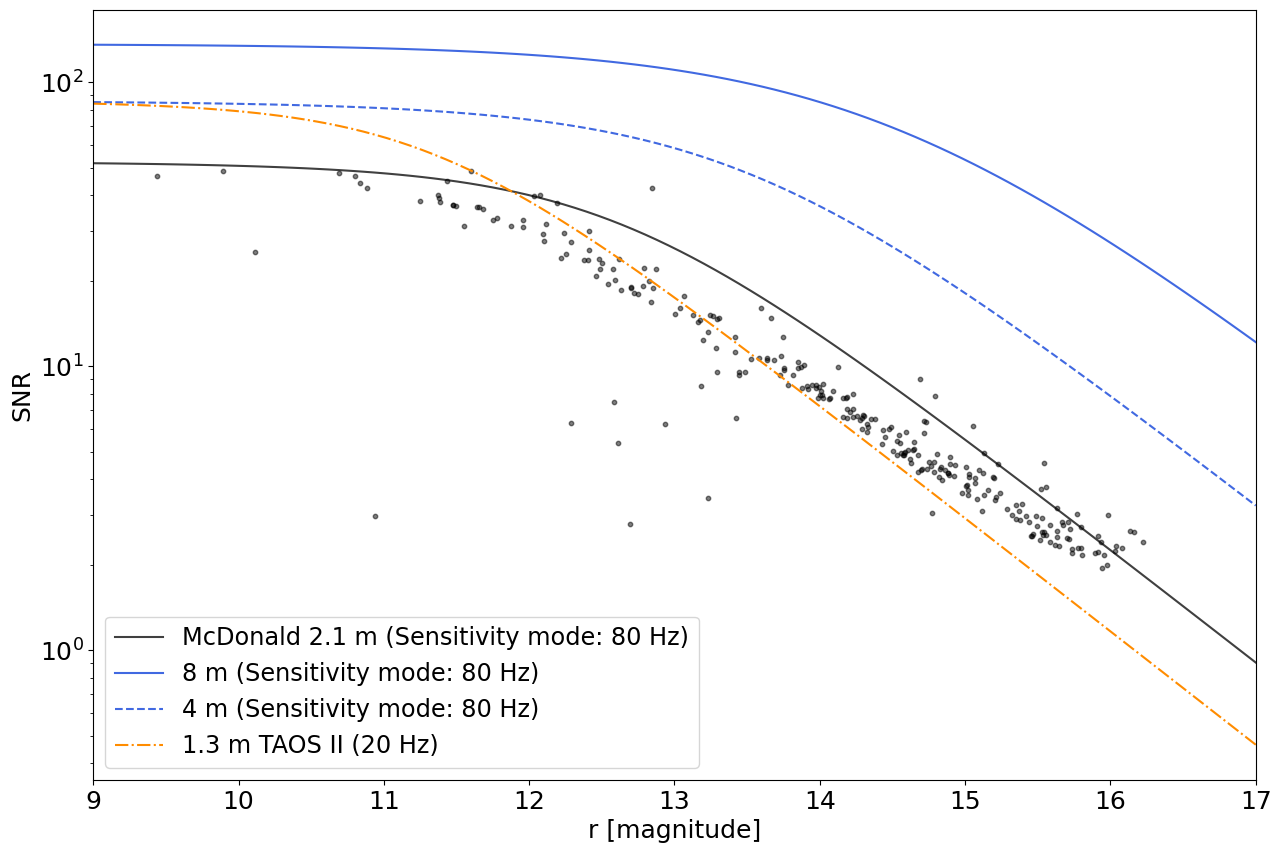

In [58]:
fs = 18
alpha = 0.5
s = 10
plt.figure(figsize=(15,10))
plt.plot(mags, snrs_theor0, c='k', linestyle='-',
         alpha=0.75, label='McDonald 2.1 m (Sensitivity mode: 80 Hz)')
plt.scatter(rmags0, snrs0, c='k', s=s, alpha=alpha)
#plt.scatter(gmags0, snrs0, c='k', s=s, alpha=alpha)
#plt.plot(mags, snrs_theor1, c='k', linestyle='--',
#         alpha=0.75, label='McDonald 2.1 m (Speed mode: 300 Hz)')
#plt.scatter(rmags1, snrs1, c='k', s=s, marker='x', alpha=alpha)
#plt.scatter(gmags1, snrs1, c='k', s=s, marker='x', alpha=alpha)
#plt.plot(mags, snrs_theor2, c='royalblue', linestyle='-', label='MSE (Sensitivity mode: 80 Hz)')
plt.plot(mags, snrs_theor2, c='royalblue', linestyle='-', label='8 m (Sensitivity mode: 80 Hz)')
plt.plot(mags, snrs_theor6, c='royalblue', linestyle='--', label='4 m (Sensitivity mode: 80 Hz)')
#plt.plot(mags, snrs_theor3, c='royalblue', linestyle='--', label='MSE (Speed mode: 300 Hz)')
plt.plot(mags, snrs_theor4, c='darkorange', linestyle='-.', label='1.3 m TAOS II (20 Hz)')
#plt.plot(mags, snrs_theor5, c='magenta', linestyle='-.', label='EMCCD (80 Hz)')
#plt.grid()
#plt.hlines(23, 9, 17, alpha=alpha)
#plt.hlines(11.27, 9, 17, linestyle='--', alpha=alpha)
plt.xlim(9, 17)
plt.tick_params(labelsize=fs)
plt.legend(fontsize='xx-large', loc='lower left')
plt.yscale('log')
plt.xlabel('r [magnitude]', fontsize=fs)
plt.ylabel('SNR', fontsize=fs)
#plt.savefig('SNR_curve.png', bbox_inches='tight')

Text(0, 0.5, 'SNR')

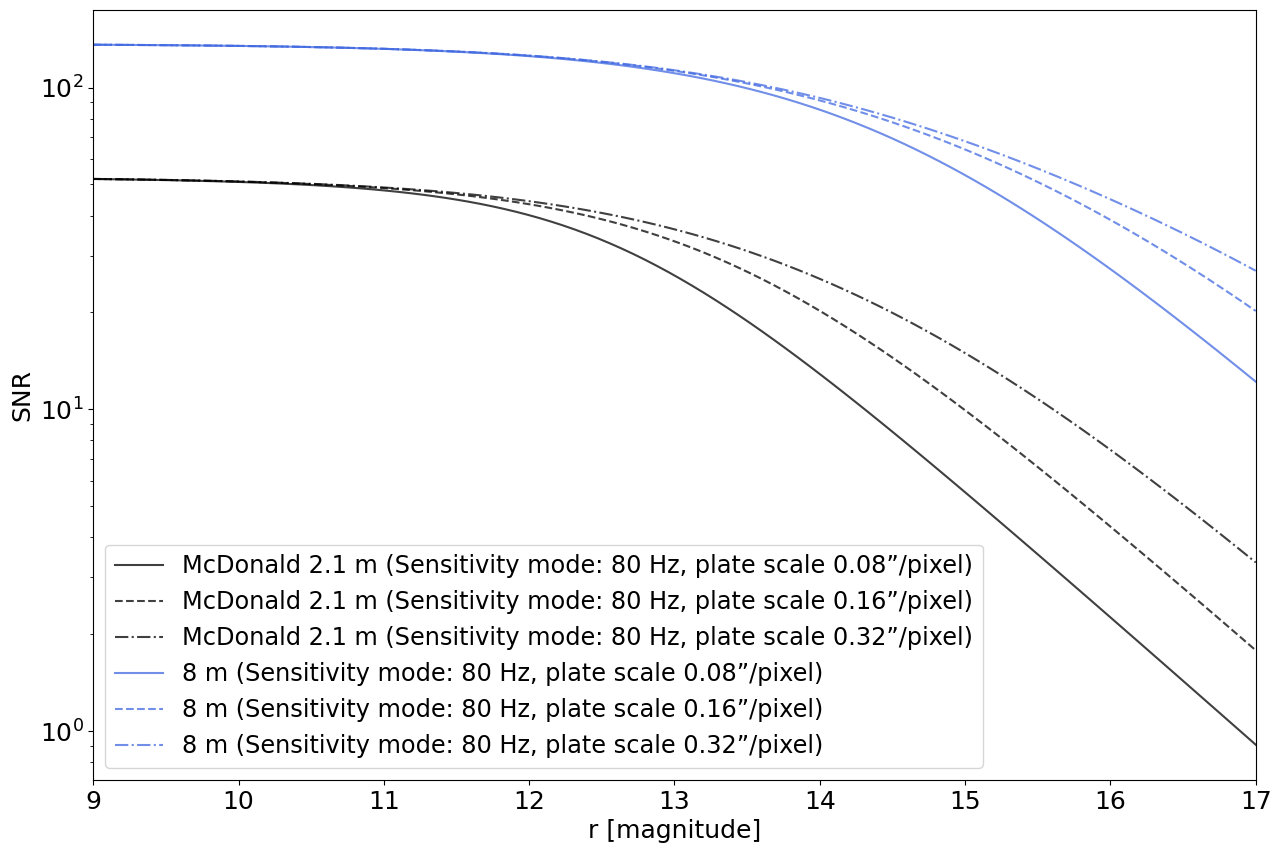

In [69]:
gamma0 = 40 * (np.pi / 180)
ap_diam0 = 58
snrs_theor0, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=2.1, h_obs=2e3)
snrs_theor1, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0 / 2, D_tel=2.1, h_obs=2e3)
snrs_theor2, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0 / 4, D_tel=2.1, h_obs=2e3)
snrs_theor3, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0, D_tel=8, h_obs=2.5e3)
snrs_theor4, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0 / 2, D_tel=8, h_obs=2.5e3)
snrs_theor5, mags = compute_theoretical_snr('Sensitivity', gamma0, b_adu_0, ap_diam0 / 4, D_tel=8, h_obs=2.5e3)

fs = 18
alpha = 0.5
s = 10
plt.figure(figsize=(15,10))
plt.plot(mags, snrs_theor0, c='k', linestyle='-',
         alpha=0.75, label='McDonald 2.1 m (Sensitivity mode: 80 Hz, plate scale 0.08”/pixel)')
plt.plot(mags, snrs_theor1, c='k', linestyle='--',
         alpha=0.75, label='McDonald 2.1 m (Sensitivity mode: 80 Hz, plate scale 0.16”/pixel)')
plt.plot(mags, snrs_theor2, c='k', linestyle='-.',
         alpha=0.75, label='McDonald 2.1 m (Sensitivity mode: 80 Hz, plate scale 0.32”/pixel)')
plt.plot(mags, snrs_theor3, c='royalblue', linestyle='-',
         alpha=0.75, label='8 m (Sensitivity mode: 80 Hz, plate scale 0.08”/pixel)')
plt.plot(mags, snrs_theor4, c='royalblue', linestyle='--',
         alpha=0.75, label='8 m (Sensitivity mode: 80 Hz, plate scale 0.16”/pixel)')
plt.plot(mags, snrs_theor5, c='royalblue', linestyle='-.',
         alpha=0.75, label='8 m (Sensitivity mode: 80 Hz, plate scale 0.32”/pixel)')

plt.xlim(9, 17)
plt.tick_params(labelsize=fs)
plt.legend(fontsize='xx-large', loc='lower left')
plt.yscale('log')
plt.xlabel('r [magnitude]', fontsize=fs)
plt.ylabel('SNR', fontsize=fs)

Text(0, 0.5, 'SNR')

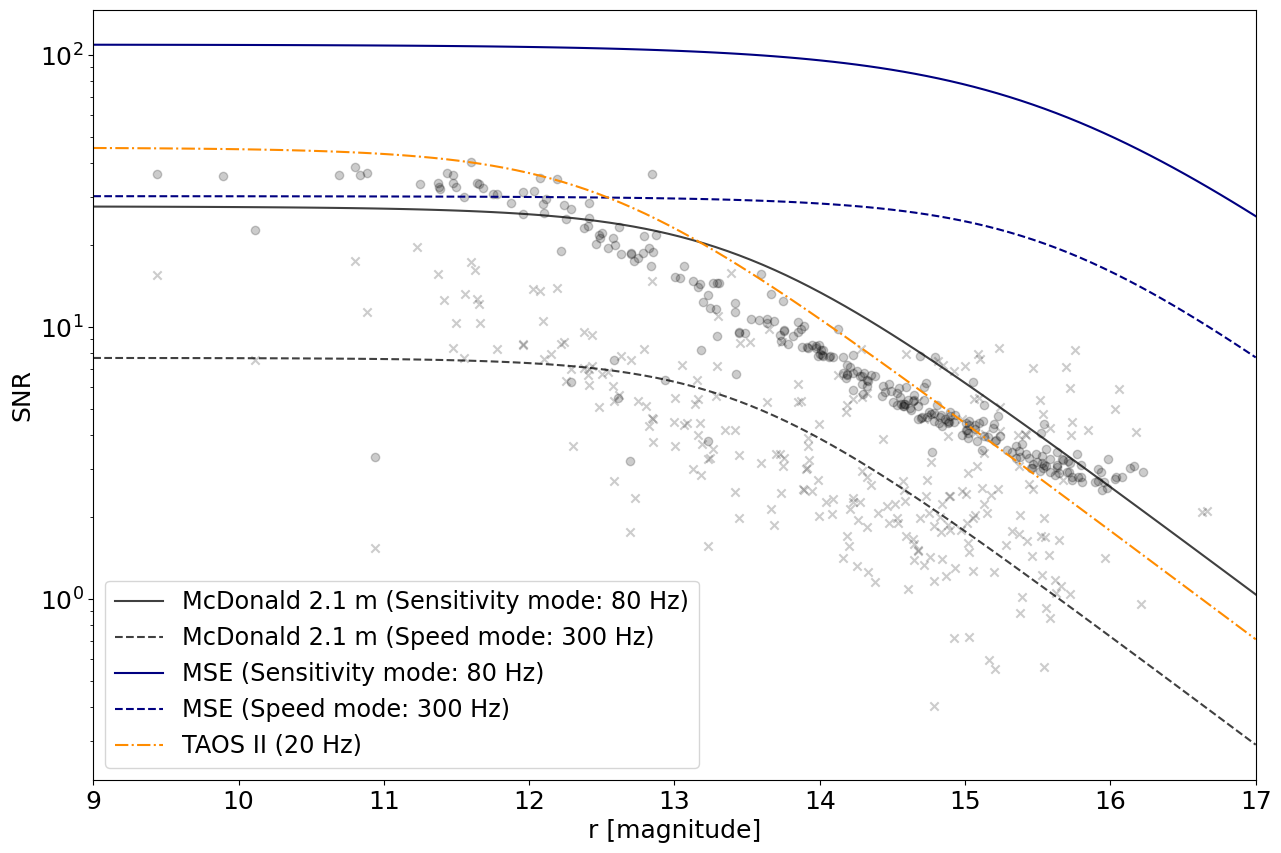

In [56]:
fs = 18
plt.figure(figsize=(15,10))
plt.plot(mags, snrs_theor0, c='k', linestyle='-',
         alpha=0.75, label='McDonald 2.1 m (Sensitivity mode: 80 Hz)')
plt.scatter(rmags0, snrs0, c='k', alpha=0.2)
plt.plot(mags, snrs_theor1, c='k', linestyle='--',
         alpha=0.75, label='McDonald 2.1 m (Speed mode: 300 Hz)')
plt.scatter(rmags1, snrs1, c='k', marker='x', alpha=0.2)
plt.plot(mags, snrs_theor2, c='navy', linestyle='-', label='MSE (Sensitivity mode: 80 Hz)')
plt.plot(mags, snrs_theor3, c='navy', linestyle='--', label='MSE (Speed mode: 300 Hz)')
plt.plot(mags, snrs_theor4, c='darkorange', linestyle='-.', label='TAOS II (20 Hz)')
#plt.grid()
alpha = 0.5
#plt.hlines(23, 9, 17, alpha=alpha)
#plt.hlines(11.27, 9, 17, linestyle='--', alpha=alpha)
plt.xlim(9, 17)
plt.tick_params(labelsize=fs)
plt.legend(fontsize='xx-large', loc='lower left')
plt.yscale('log')
plt.xlabel('r [magnitude]', fontsize=fs)
plt.ylabel('SNR', fontsize=fs)
#plt.savefig('SNR_curve.png', bbox_inches='tight')

In [ ]:
# over correction of top end
# leaking of neighbour flux in faint sources (crowded field)

In [20]:
# lab test flux check
import os
import numpy as np
import matplotlib.pyplot as plt

path = "D:/offline_tests/results_scene_0"
data = np.load(os.path.join(path, 'skys_batch0.npy'))
#data = np.load(os.path.join(path, 'photometry_batch0.npy'))
data.shape

(100, 8)

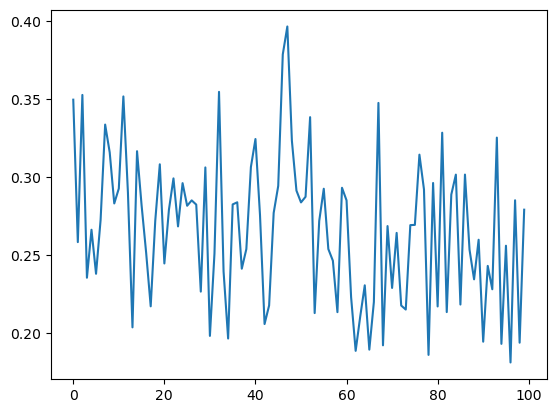

In [21]:
plt.plot(data[:,0])

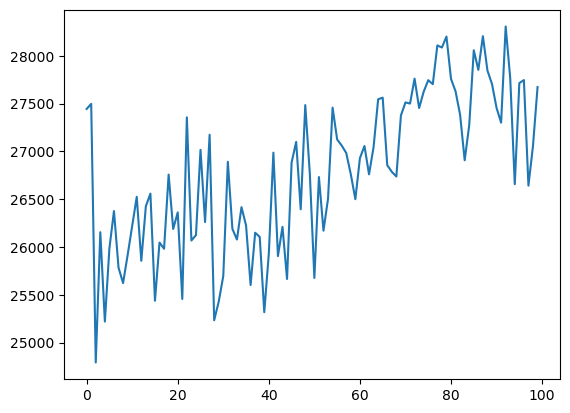

In [17]:
plt.plot(data[:,0])

In [ ]:
# HST star hours 19,500, Nature paper star hours 6.05e4
# HST:r = 530 ± 70 m and a distance of 35 ± 9 AU.
# Nature: KBO, radius of ~1.3 km
# TAOS (I): star hours 292,514
# X-ray Oort paper: 1.6 Ms i.e. 444 star hours
# McDonald star hours (per night)
# ~200 stars per field, observe for ~8 hours per night
# star hours = 200 * 8 = 1600 hours per night